In [ ]:
!pip install -q arabert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186459 sha256=658cf2116bca99dc6a370300ba30b0dae9c96419908591602a6a3bb6569f5128
  Stored in directory: /root/.cache/pip/wheels/10/f0/fd/4813b1177405693e8da9cdea839f0fb64fde161380e058c827
Successfully built emoji


In [ ]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 2.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
df=pd.read_csv('df_ar_t.csv')

In [ ]:
del df['Unnamed: 0']


In [ ]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import copy
import pandas as pd
from typing import List
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split


from arabert.preprocess import ArabertPreprocessor
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments)
from transformers.data.processors.utils import InputFeatures

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "aubmindlab/bert-base-arabertv02-twitter"
arabert_prep = ArabertPreprocessor(model_name=model_name)

# Apply preprocessing to your comments
df['comment'] = df['comment'].apply(arabert_prep.preprocess)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/476 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/751k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['be

In [ ]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark = False
training_args = TrainingArguments(
    output_dir= "./train",
    adam_epsilon = 1e-8,
    learning_rate = 1e-4,
    fp16 = False, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 32, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 32,
    gradient_accumulation_steps = 5, # use this to scale batch size without needing more memory
    num_train_epochs= 2,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    greater_is_better = True,
    seed = 42
  )

set_seed(training_args.seed)

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy='epoch',
)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import time

# Define Dataset
class CommentsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
training_start = time.time()
# Tokenize comments
encodings = tokenizer(list(df['comment'].values), truncation=True, padding=True, max_length=364)

# Create dataset
dataset = CommentsDataset(encodings, list(df['label'].values))

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()
training_end = time.time()
print(f"Training time: {training_end - training_start} seconds")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,No log,0.408797
1,No log,0.451265


Training time: 216.93880915641785 seconds


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  f1 = f1_score(labels, preds, average='macro')
  precision = precision_score(labels, preds, average='macro')
  recall = recall_score(labels, preds, average='macro')
  return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}
predictions = trainer.predict(val_dataset)
metrics = compute_metrics(predictions)
print(f"Accuracy: {metrics['accuracy']}, F1-Score: {metrics['f1']}, Precision: {metrics['precision']}, Recall: {metrics['recall']}")

Accuracy: 0.7965383256799717, F1-Score: 0.7949262786170261, Precision: 0.7964096268679337, Recall: 0.7941715299921785


In [ ]:
# Define the output directory
output_dir = "./saved_model"

# Save the model
model.save_pretrained(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

In [ ]:

# Get the predictions on the validation set
predictions, labels, _ = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Identify misclassified instances
misclassified_indices = np.where(predicted_labels != labels)[0]

# Extract the misclassified instances
misclassified_comments = [val_dataset[i]['input_ids'].tolist() for i in misclassified_indices]
true_labels = [labels[i] for i in misclassified_indices]
predicted_labels_misclassified = [predicted_labels[i] for i in misclassified_indices]

# Decode the input_ids to get the original comments (if needed)
misclassified_comments_decoded = [tokenizer.decode(ids, skip_special_tokens=True) for ids in misclassified_comments]

# Combine the results into a list of dictionaries
misclassified_instances = [{
    'comment': comment,
    'true_label': true,
    'predicted_label': pred
} for comment, true, pred in zip(misclassified_comments_decoded, true_labels, predicted_labels_misclassified)]

# Create a DataFrame from the misclassified instances
misclassified_df = pd.DataFrame(misclassified_instances)

# Display or save the DataFrame as needed
misclassified_df

,comment,true_label,predicted_label
0,إن شاء اله تكمل على خير لانو المظاهرات كاثرة ف...,1,0
1,هال تعرف كيف يكون الإحتفال بنبي صلى اله عليه و...,1,0
2,لحقيقة بينا جا زائر داليما ستختفي في لخريطة ث ...,1,0
3,ه واله انا خفت في بلاصتها تستاهل لوكان سترت روحها,1,0
4,لا أحد يستحق مكانه حتى ينسخ كاتب لا يعرفونه حتى,1,0
...,...,...,...
571,النسا تاع دروك يلبسو المزير يتبرجو يزيدو يقولو...,0,1
572,يا المروكي لمادا اعلامكم يسب ويشتم اجزائرسعبا ...,0,1
573,بزاف عليكم لبرامج المغربية هاربين عليكم بسنوات...,0,1
574,ف ساي ماعرفتش واش نأمن الجزاءرهياخرمستعمرةفياف...,0,1


In [ ]:
misclassified_df

,comment,true_label,predicted_label
0,يحسبونه هينا وهو عند اله عظيم اطارات خرجي سنة ...,0,1
1,الترقي جاوب صحيح همشوهم ماشي غرظو اكبر علامة ف...,0,1
2,برافو مولات 10 في الباك هو مول 1 تمنيت اكون في...,1,0
3,الناس طلعو لقمرونتوما كي التابعة دمرو فالبلاد ...,0,1
4,مكبوتين جاية من كلمة الكبت و واحد مكبوت تسمى م...,1,0
...,...,...,...
147,تبون الجزائرين اولادك دير بيهم ما بغيتي خلي اع...,1,0
148,العبوا بالجزائرهاذي هي امانة الشهداء و اسفاه و...,0,1
149,بزاف عليكم لبرامج المغربية هاربين عليكم بسنوات...,0,1
150,كيتبورض علهم بتبوريظة المغربية ه فاقد الشى لاي...,1,0


In [ ]:
# prompt: Using dataframe misclassified_df: save it as csv

misclassified_df.to_csv('misclassified.csv', index=False)


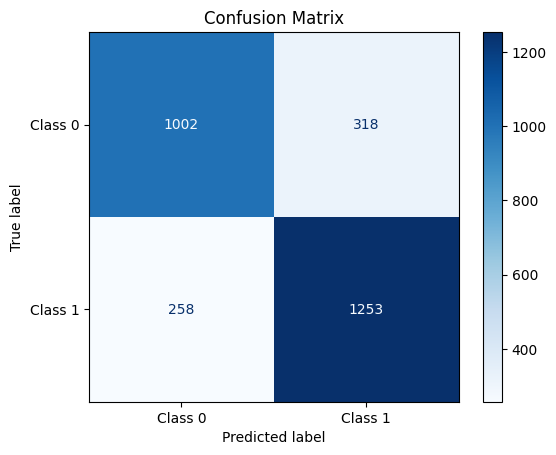

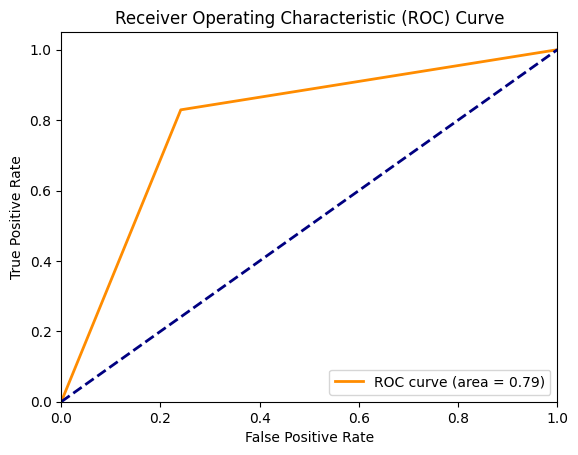

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from transformers import Trainer

def plot_confusion_matrix_and_roc(trainer: Trainer, val_dataset, label_names):
    # Put model in evaluation mode
    trainer.model.eval()

    # Get predictions
    predictions, labels, _ = trainer.predict(val_dataset)
    predictions = np.argmax(predictions, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.savefig('cm_filename')
    plt.show()

    # Compute ROC curve and AUC for each class
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.savefig('roc_filename')
    plt.legend(loc="lower right")
    plt.show()

# Example usage:
label_names = ['Class 0', 'Class 1']  # Replace with your actual class names
plot_confusion_matrix_and_roc(trainer, val_dataset, label_names)


In [ ]:
plt.savefig('roc_filename')

<Figure size 640x480 with 0 Axes>

In [ ]:
!pip install accelerate -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
!pip install transformers==4.30

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 26.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.0
    Uninstalling transformers-4.41.0:
      Successfully uninstalled transformers-4.41.0
